In [35]:
import re
import pandas as pd
import os
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.spatial.distance import squareform
from scipy.stats import ttest_ind
from itertools import combinations
import random
import numpy as np
import math

%cd ~/t3ss_effectors/

/Users/thiberio/t3ss_effectors


In [15]:
proteins = pd.Series()
for line in open('proteins_per_genome.txt').readlines():
    line = line.split(':')
    proteins[line[0].replace('.faa', '')] = int(line[1].strip())

In [16]:
proteins.head()

A_allosaccharophila_ATCC35942    4079
A_allosaccharophila_BVH88        4295
A_allosaccharophila_CECT4199T    4173
A_aquariorum_AAK1                4274
A_aquariorum_CECT7289T           4266
dtype: int64

In [13]:
effector_occurrence = {}
for filename in os.listdir('.'):
    if not filename.endswith('.faa'):
        continue
    headers = re.findall('^>(\S+)', open(filename).read(), re.M)
    effector_occurrence[filename.replace('.faa', '')] = []
    for header in headers:
        if header.startswith('gi'):
            continue
        header = header.split('|')
        if len(header) == 1:
            effector_occurrence[filename.replace('.faa', '')].extend(header)
        elif header[0].startswith('A_'):
            effector_occurrence[filename.replace('.faa', '')].append(header[0])
        else:
            effector_occurrence[filename.replace('.faa', '')].append(header[1])

In [14]:
apparatus = open('apparatus_occurrence').read()
apparatus = apparatus.split('\n')
apparatus.pop()
apparatus = [line.split('\\t') for line in apparatus]
for position, line in enumerate(apparatus):
    if len(line) == 1:
        line.append('')
apparatus = np.asarray(apparatus)

apparatus_df = pd.DataFrame(
    columns=['1', '2'],
    index  =apparatus[:,0],
    data   =0)
for line in apparatus:
    if not line[1]:
        continue
    for value in apparatus_df.columns:
        if value in line[1]:
            apparatus_df.loc[line[0], value]  = 1

In [15]:
effector_df = pd.DataFrame(
                  columns = effector_occurrence.keys(),
                  index   = apparatus[:,0],
                  data    = 0)
for effector, genomes in effector_occurrence.items():
    effector_df.loc[genomes, effector] = 1

In [110]:
#effector saturation
max_combinations = 10000
combinations_df = pd.DataFrame(columns=['distinct_effectors', 'num_genomes'])
for n in range(2, 105):    
    y_axis = []
    index_combinations = set()
    num_possible_combinations = math.factorial(105)/(math.factorial(n)*math.factorial(105-n))
    
    if num_possible_combinations > max_combinations:
        while len(index_combinations) < max_combinations:
            indexes = random.sample(list(effector_df.index), n)
            if frozenset(indexes) in index_combinations:
                continue
            index_combinations.add(frozenset(indexes))
            distinct_effectors = sum(effector_df.loc[indexes].sum() >= 1)
            y_axis.append(distinct_effectors)
    else:
        for indexes in combinations(effector_df.index.tolist(), n):
            indexes = list(indexes)
            distinct_effectors = sum(effector_df.loc[indexes].sum() >= 1)
            y_axis.append(distinct_effectors)
    
    tmp = pd.DataFrame(columns=['distinct_effectors', 'num_genomes'],
                       data=list(zip(y_axis, [n]*len(y_axis))))
    combinations_df = combinations_df.append(tmp, ignore_index=True)

In [112]:
avg_num_effectors = [combinations_df.query('num_genomes == %i' % n).distinct_effectors.mean()
                     for n in range(2,105)]

In [115]:
list(enumerate(avg_num_effectors, 2))

[(2, 4.491575091575092),
 (3, 5.9622),
 (4, 7.1164),
 (5, 8.15),
 (6, 8.9065),
 (7, 9.6389),
 (8, 10.2857),
 (9, 10.8334),
 (10, 11.3667),
 (11, 11.8353),
 (12, 12.2565),
 (13, 12.6174),
 (14, 13.0702),
 (15, 13.4435),
 (16, 13.7135),
 (17, 14.0905),
 (18, 14.4287),
 (19, 14.6885),
 (20, 14.9454),
 (21, 15.2401),
 (22, 15.5064),
 (23, 15.795),
 (24, 15.9886),
 (25, 16.1987),
 (26, 16.4449),
 (27, 16.6426),
 (28, 16.7997),
 (29, 17.0579),
 (30, 17.1881),
 (31, 17.3415),
 (32, 17.5837),
 (33, 17.753),
 (34, 17.9063),
 (35, 18.0555),
 (36, 18.2199),
 (37, 18.3503),
 (38, 18.5046),
 (39, 18.6257),
 (40, 18.7376),
 (41, 18.8885),
 (42, 18.9782),
 (43, 19.1032),
 (44, 19.2006),
 (45, 19.3178),
 (46, 19.4731),
 (47, 19.5728),
 (48, 19.6789),
 (49, 19.7196),
 (50, 19.8669),
 (51, 19.967),
 (52, 20.0301),
 (53, 20.1164),
 (54, 20.2026),
 (55, 20.297),
 (56, 20.3608),
 (57, 20.467),
 (58, 20.5486),
 (59, 20.6061),
 (60, 20.6558),
 (61, 20.7794),
 (62, 20.8432),
 (63, 20.9004),
 (64, 20.9996),
 (

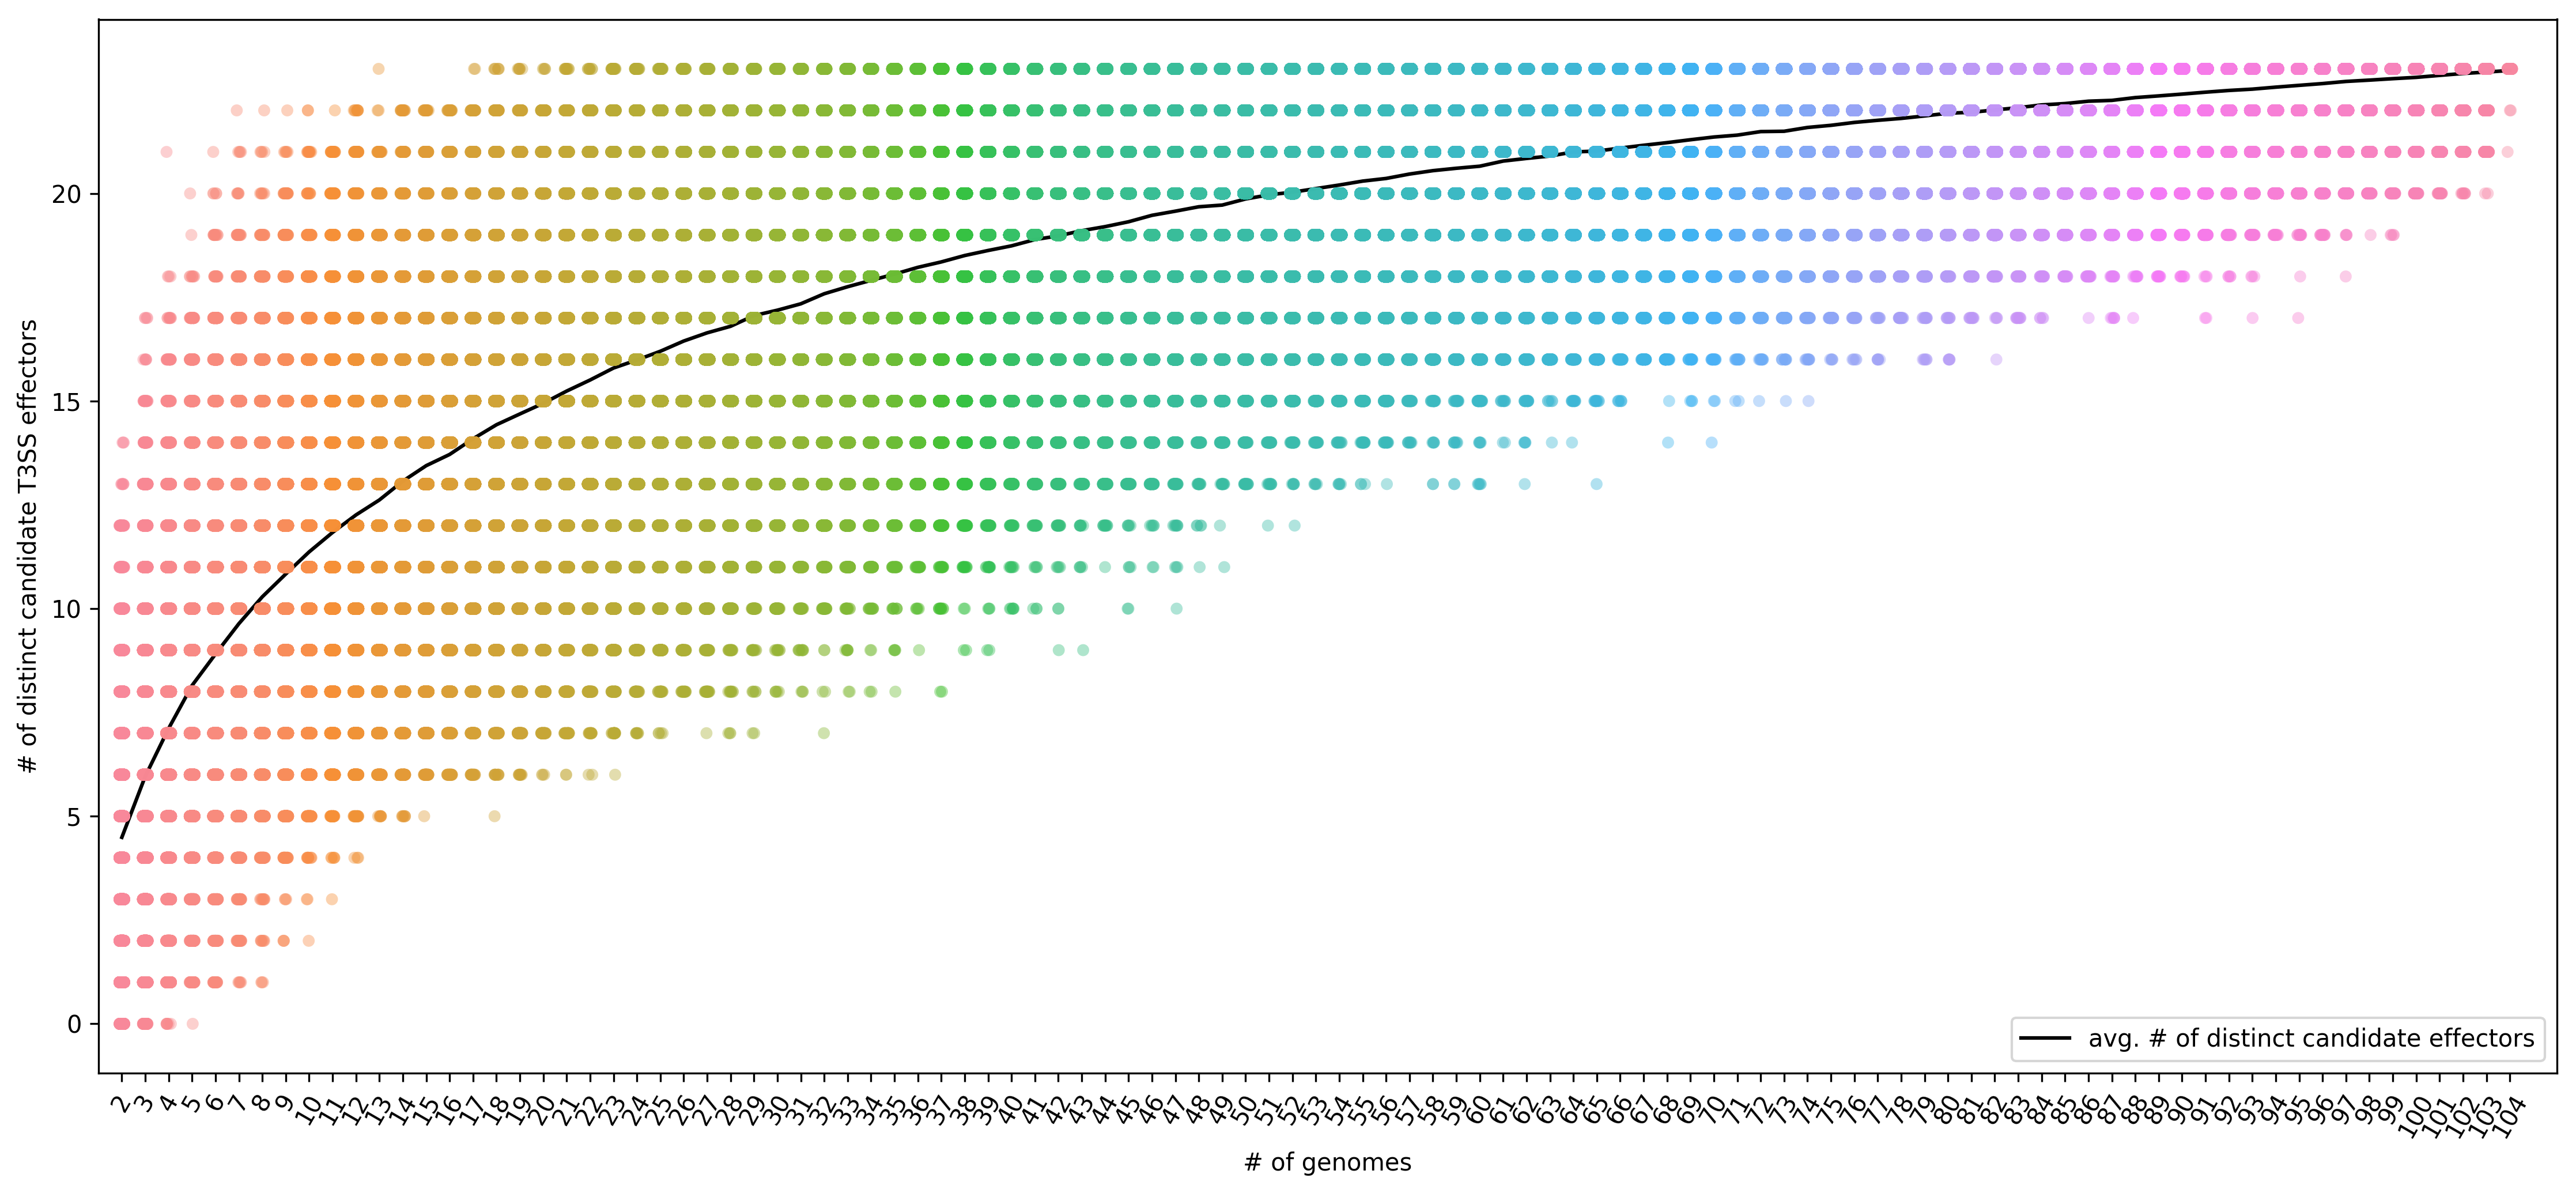

In [131]:
fig, ax = plt.subplots(figsize=(15,7), dpi=300)
sns.stripplot(x='num_genomes', y='distinct_effectors', data=combinations_df, ax=ax, alpha=0.4)
ax.plot(range(0,103),
        avg_num_effectors,
        'k-',
        label='avg. # of distinct candidate effectors')
ax.set_xlim(-1, 104)
plt.xticks(rotation=60)
ax.set_xlabel('# of genomes')
ax.set_ylabel('# of distinct candidate T3SS effectors')
ax.legend()
fig.tight_layout()
fig.savefig('saturation_curve.png')

In [106]:
effectors_without_apparatus = {}
for effector, column in effector_df.iteritems():
    genomes = column[column==1].index
    
    tmp = apparatus_df.loc[genomes].copy()
    tmp = tmp[(tmp['1'] == 0) & (tmp['2'] == 0)]
    if not tmp.shape[0]:
        continue
    
    effectors_without_apparatus[effector] = tmp.index.tolist()

In [12]:
with_apparatus    = apparatus_df.index[apparatus_df.T.sum() > 0]
without_apparatus = apparatus_df.index[apparatus_df.T.sum() == 0]

/Users/thiberio/anaconda2/envs/py37/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Ttest_indResult(statistic=-1.6783981108478327, pvalue=0.09630104935921772)

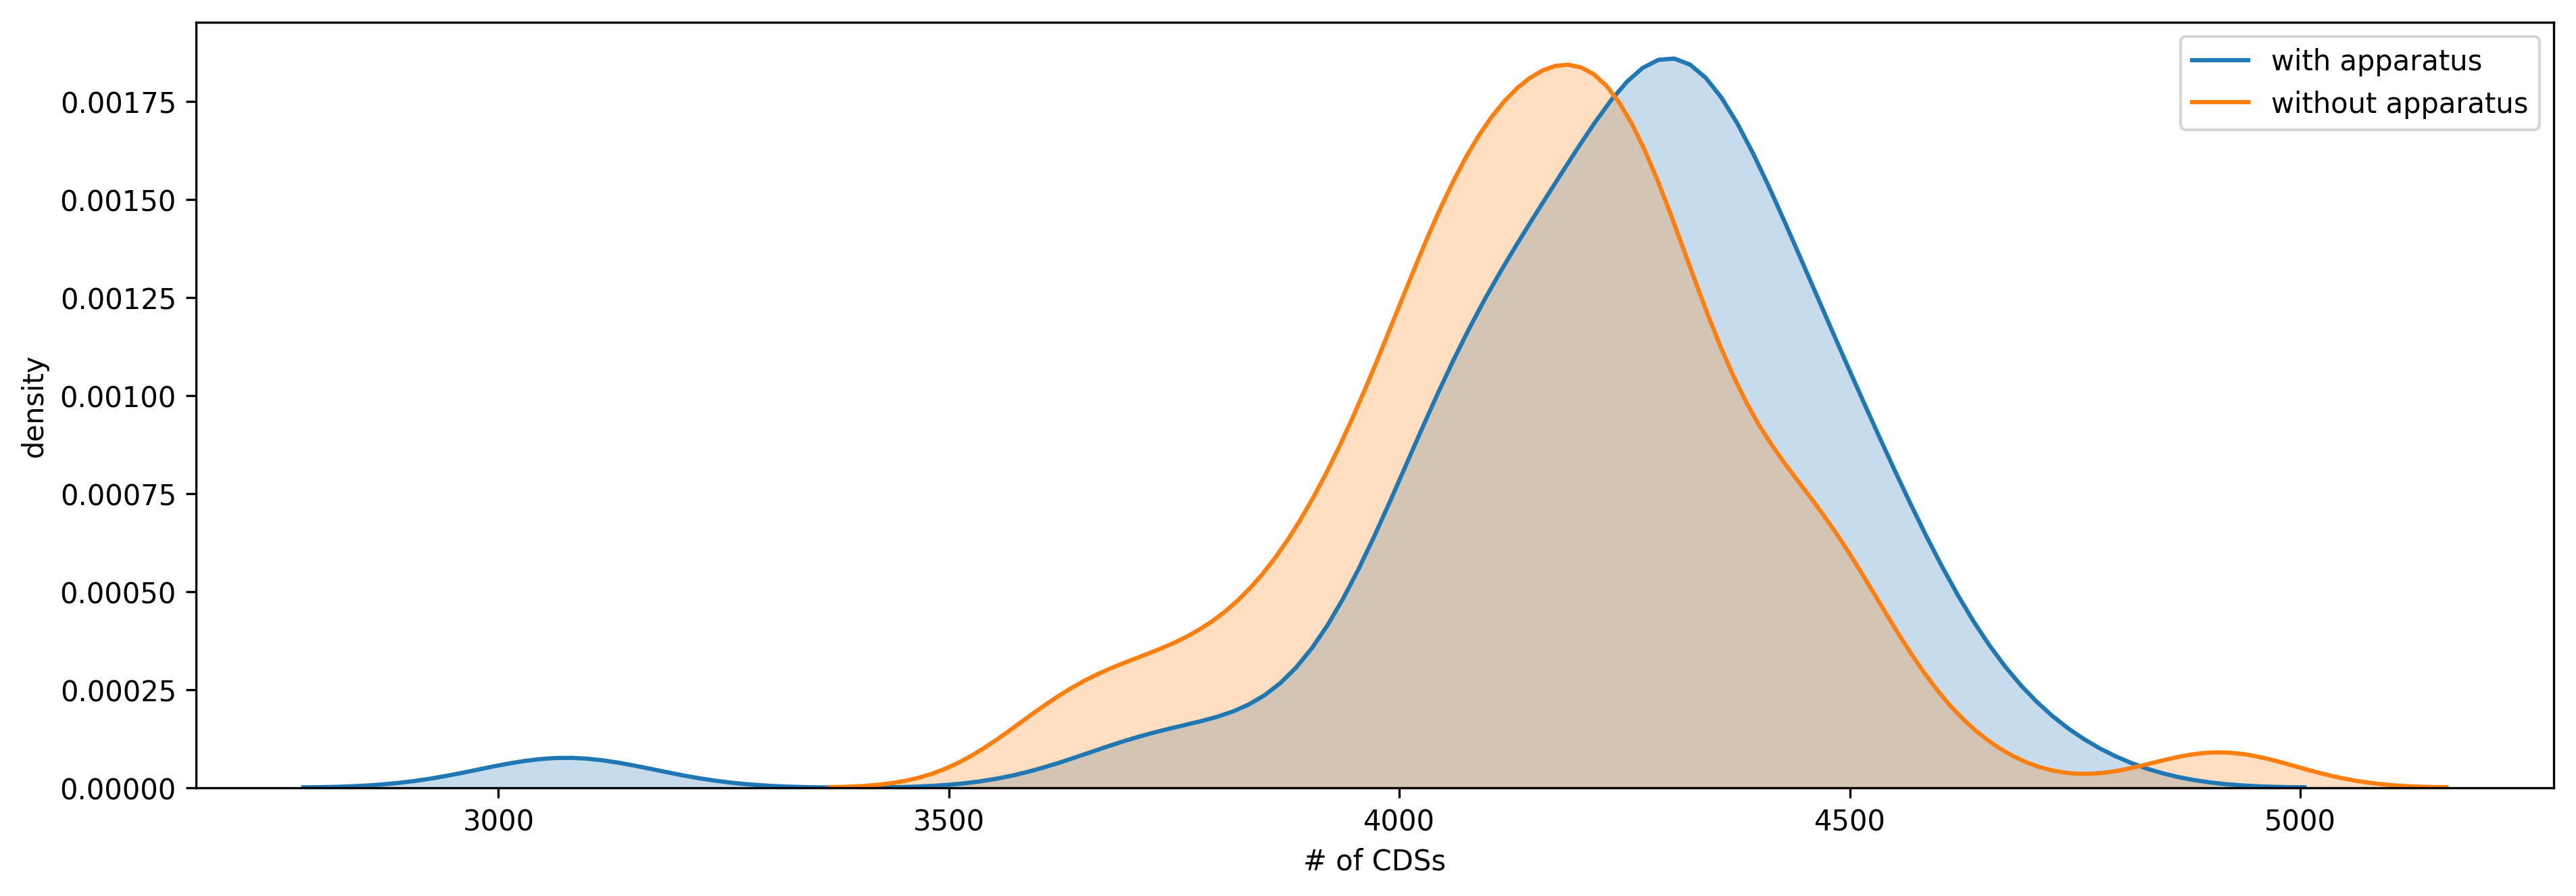

In [22]:
fig, ax = plt.subplots(dpi=300, figsize=(15,5))
sns.kdeplot(proteins[with_apparatus].values,
            ax=ax,
            shade=True,
            label='with apparatus')
sns.kdeplot(proteins[without_apparatus].values,
            ax=ax,
            shade=True,
            label='without apparatus')
ax.set_xlabel('# of CDSs')
ax.set_ylabel('density')
ttest_ind(proteins[without_apparatus].values, proteins[with_apparatus].values)
#fig.savefig('genomes_per_effectors', dpi=300)

/Users/thiberio/anaconda2/envs/py37/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


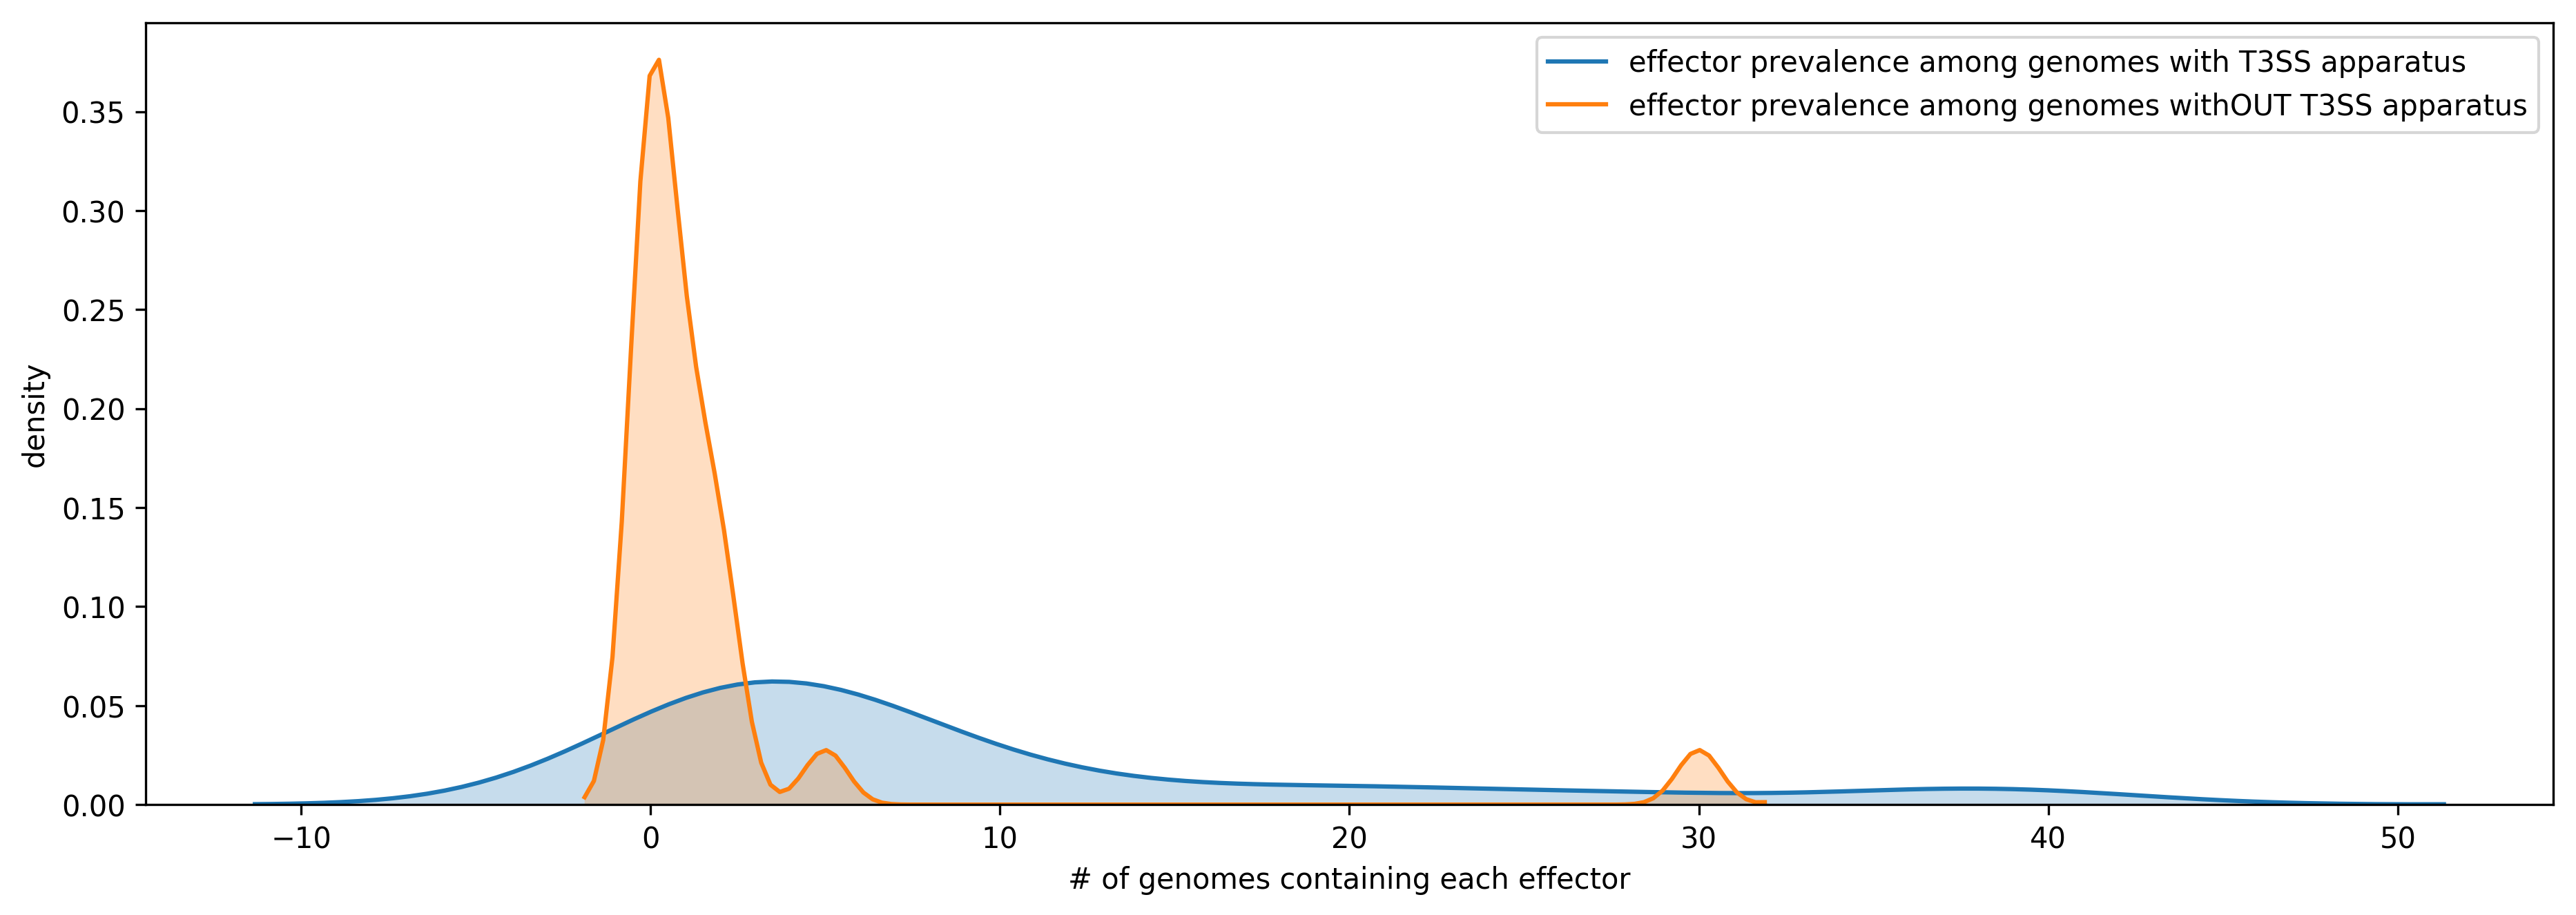

In [175]:
fig, ax = plt.subplots(dpi=300, figsize=(15,5))
sns.kdeplot(effector_df.loc[with_apparatus].sum().values,
            ax=ax,
            shade=True,
            label='effector prevalence among genomes with T3SS apparatus')
sns.kdeplot(effector_df.loc[without_apparatus].sum().values,
            ax=ax,
            shade=True,
            label='effector prevalence among genomes withOUT T3SS apparatus')
ax.set_xlabel('# of genomes containing each effector')
ax.set_ylabel('density')
fig.savefig('genomes_per_effectors', dpi=300)

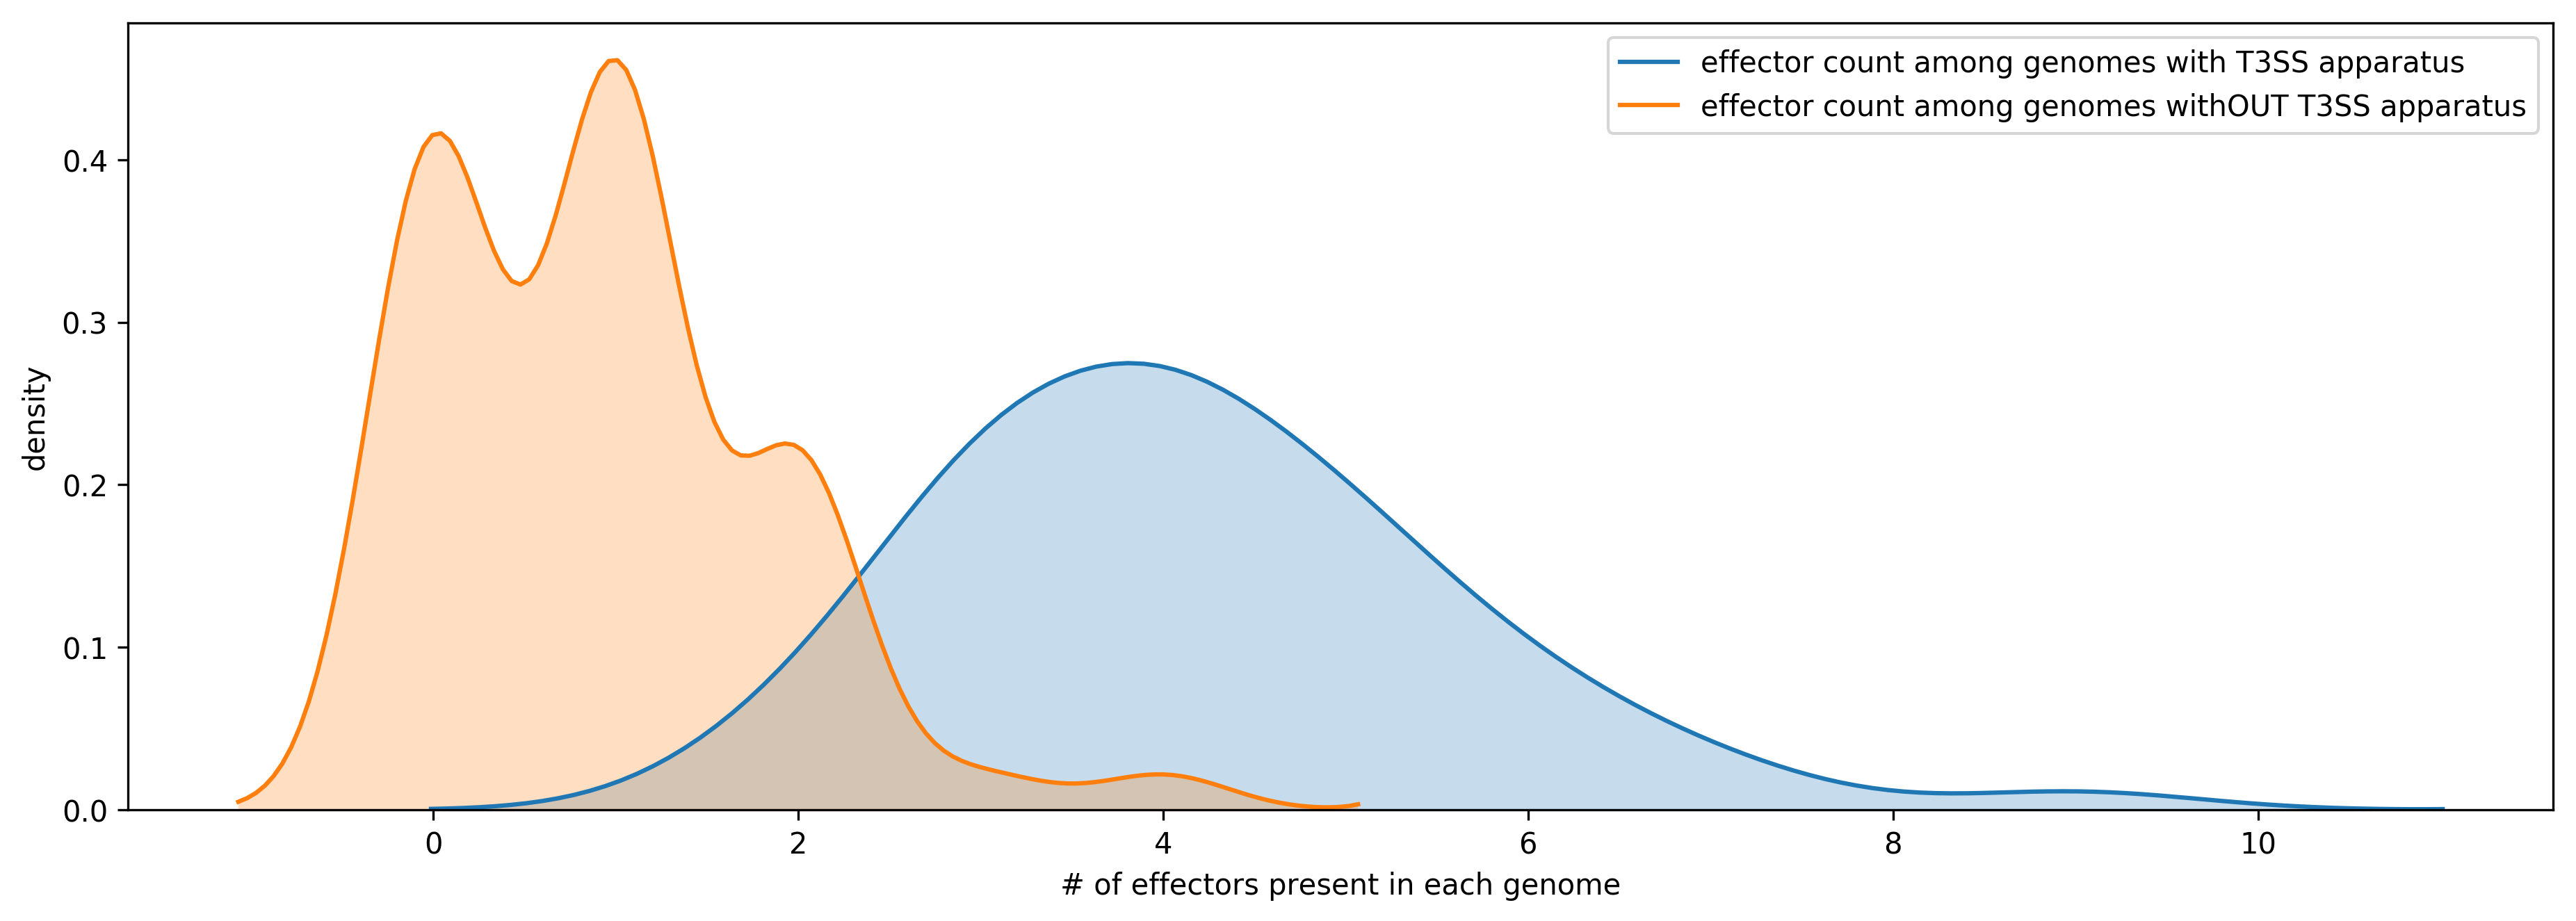

In [176]:
fig, ax = plt.subplots(dpi=300, figsize=(15,5))
sns.kdeplot(effector_df.loc[with_apparatus].T.sum().values,
            ax=ax,
            shade=True,
            label='effector count among genomes with T3SS apparatus')
sns.kdeplot(effector_df.loc[without_apparatus].T.sum().values,
            ax=ax,
            shade=True,
            label='effector count among genomes withOUT T3SS apparatus')
ax.set_xlabel('# of effectors present in each genome')
ax.set_ylabel('density')
fig.savefig('effectors_per_genome', dpi=300)

In [290]:
for effector in effectors_without_apparatus.keys():
    print(effector,
          round(len(effectors_without_apparatus[effector])/effector_df[effector].sum()*100, 2),
          effector_df[effector].sum())

AopH 11.11 9
PteE 69.77 43
PteB 6.67 30
AopO 20.0 5
PteA 18.52 27
PteM 100.0 2
PteK 9.09 11
aopP 16.67 6
AexU 4.76 42
AexT 10.0 20
PteM.1 100.0 1


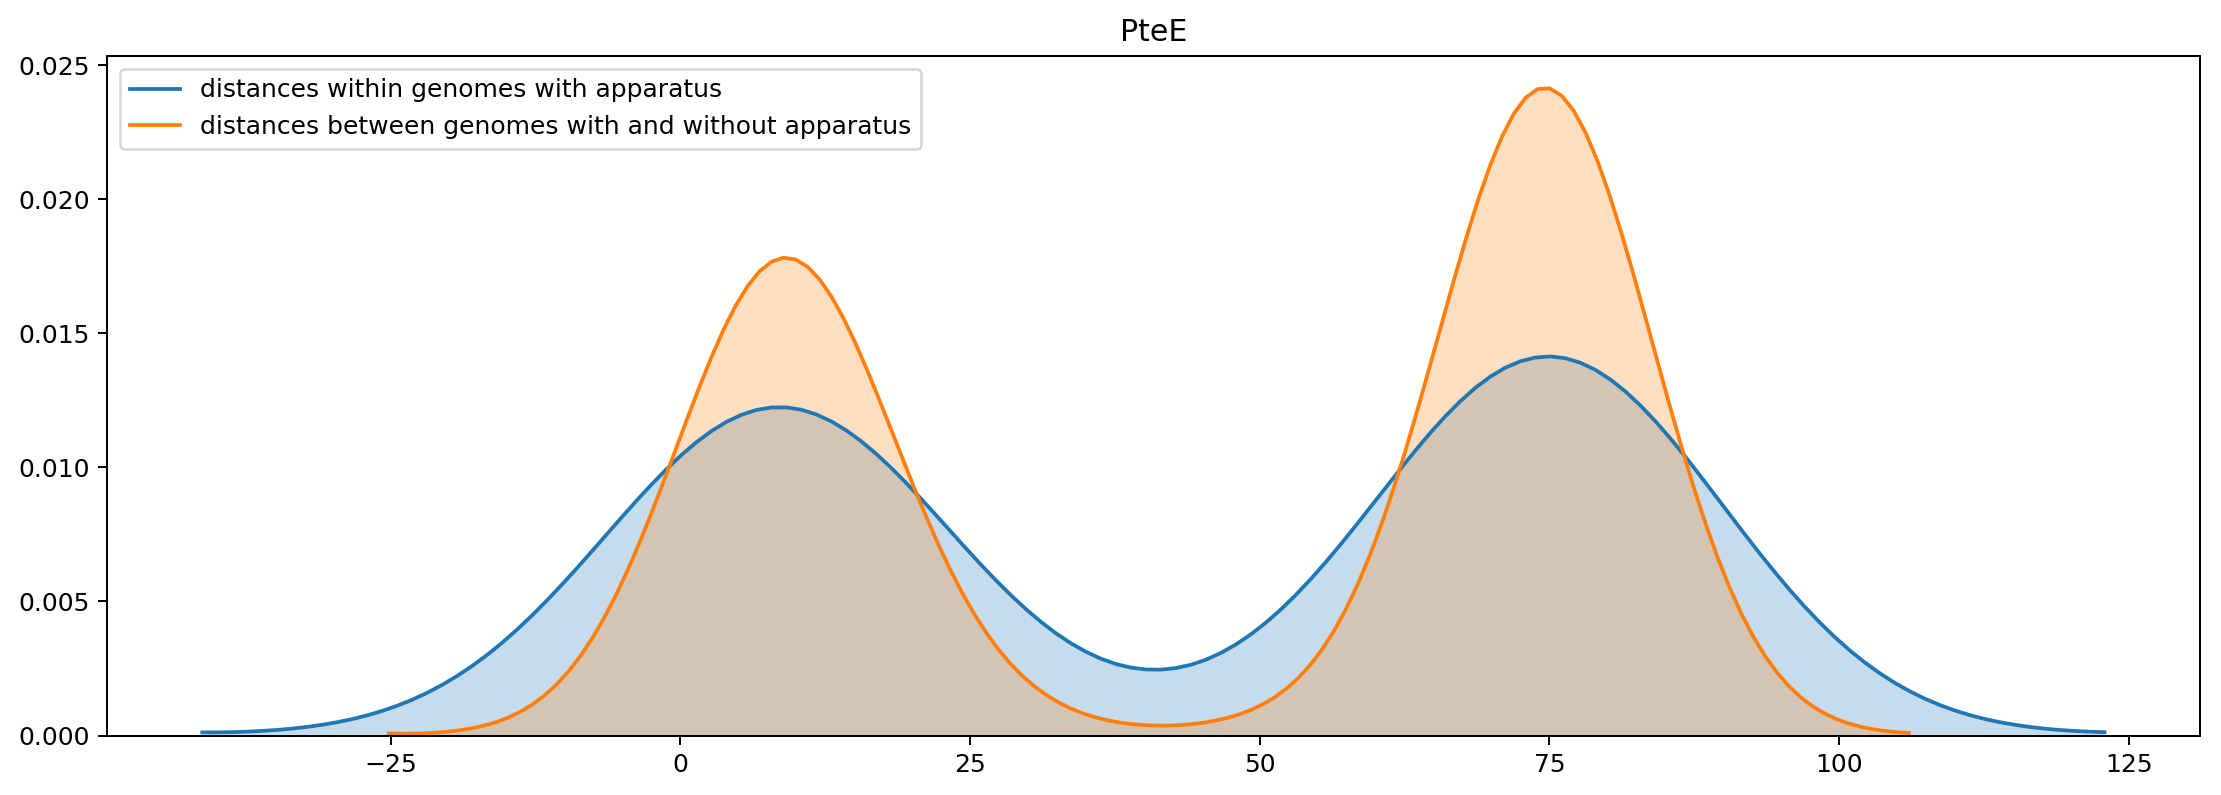

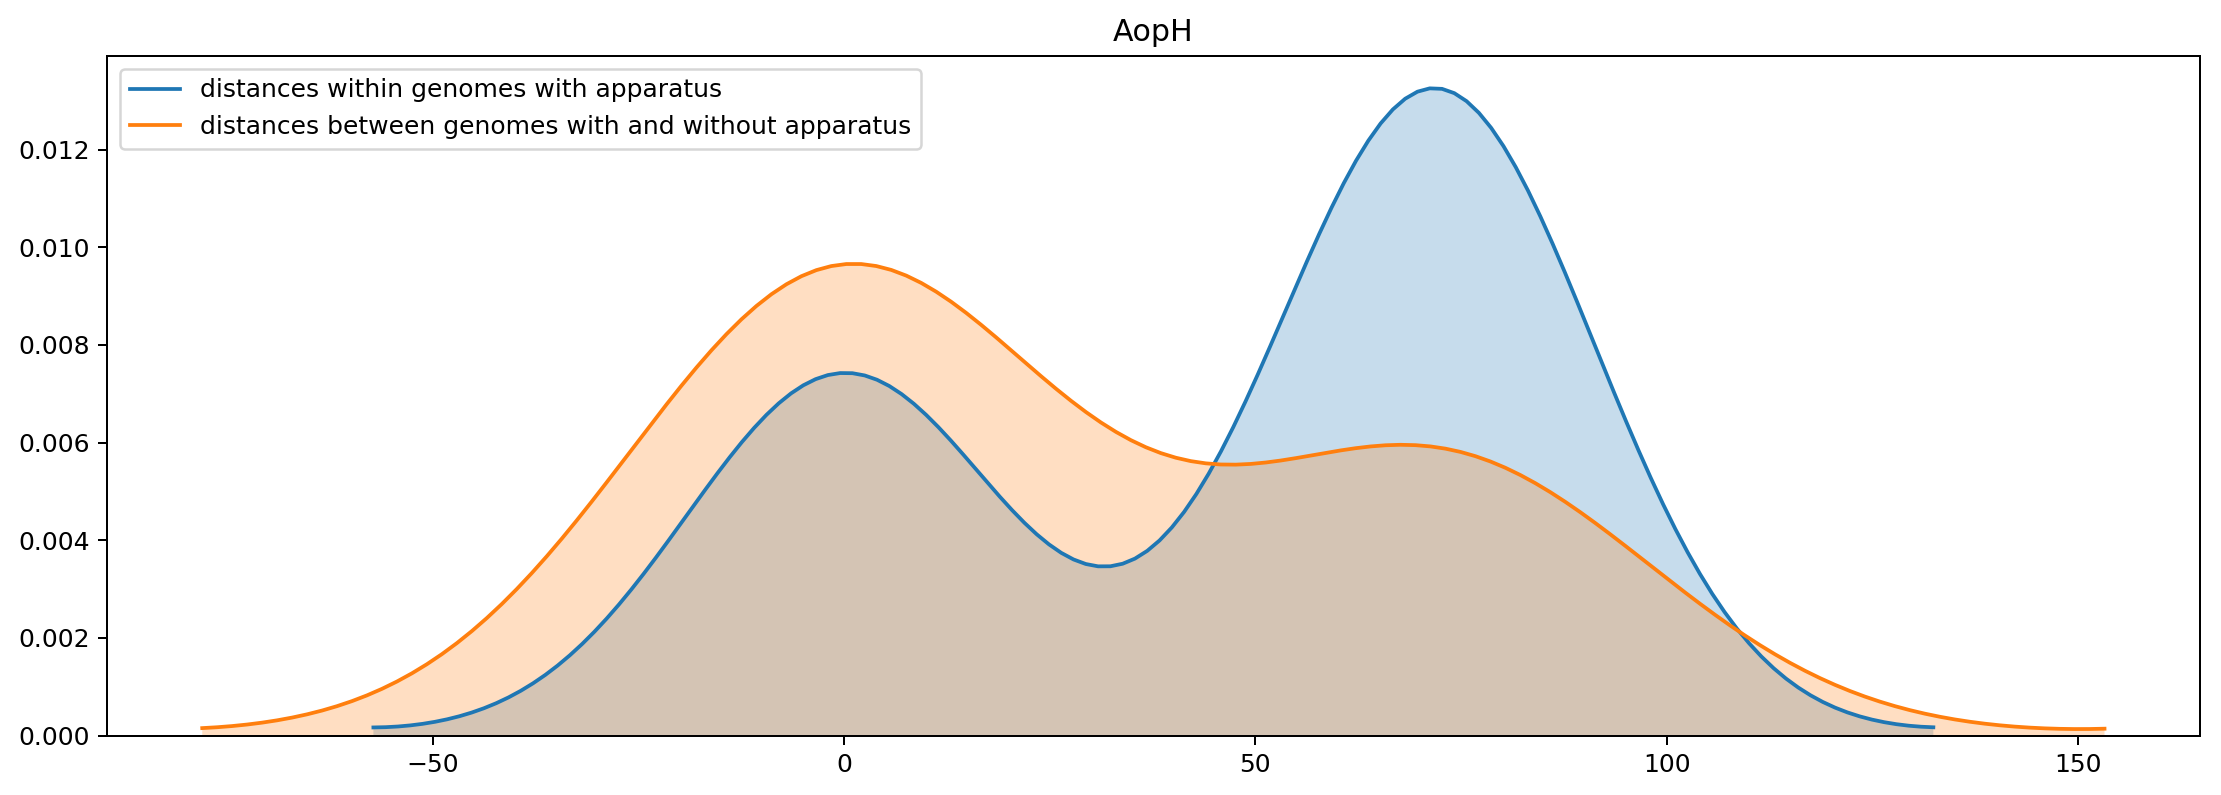

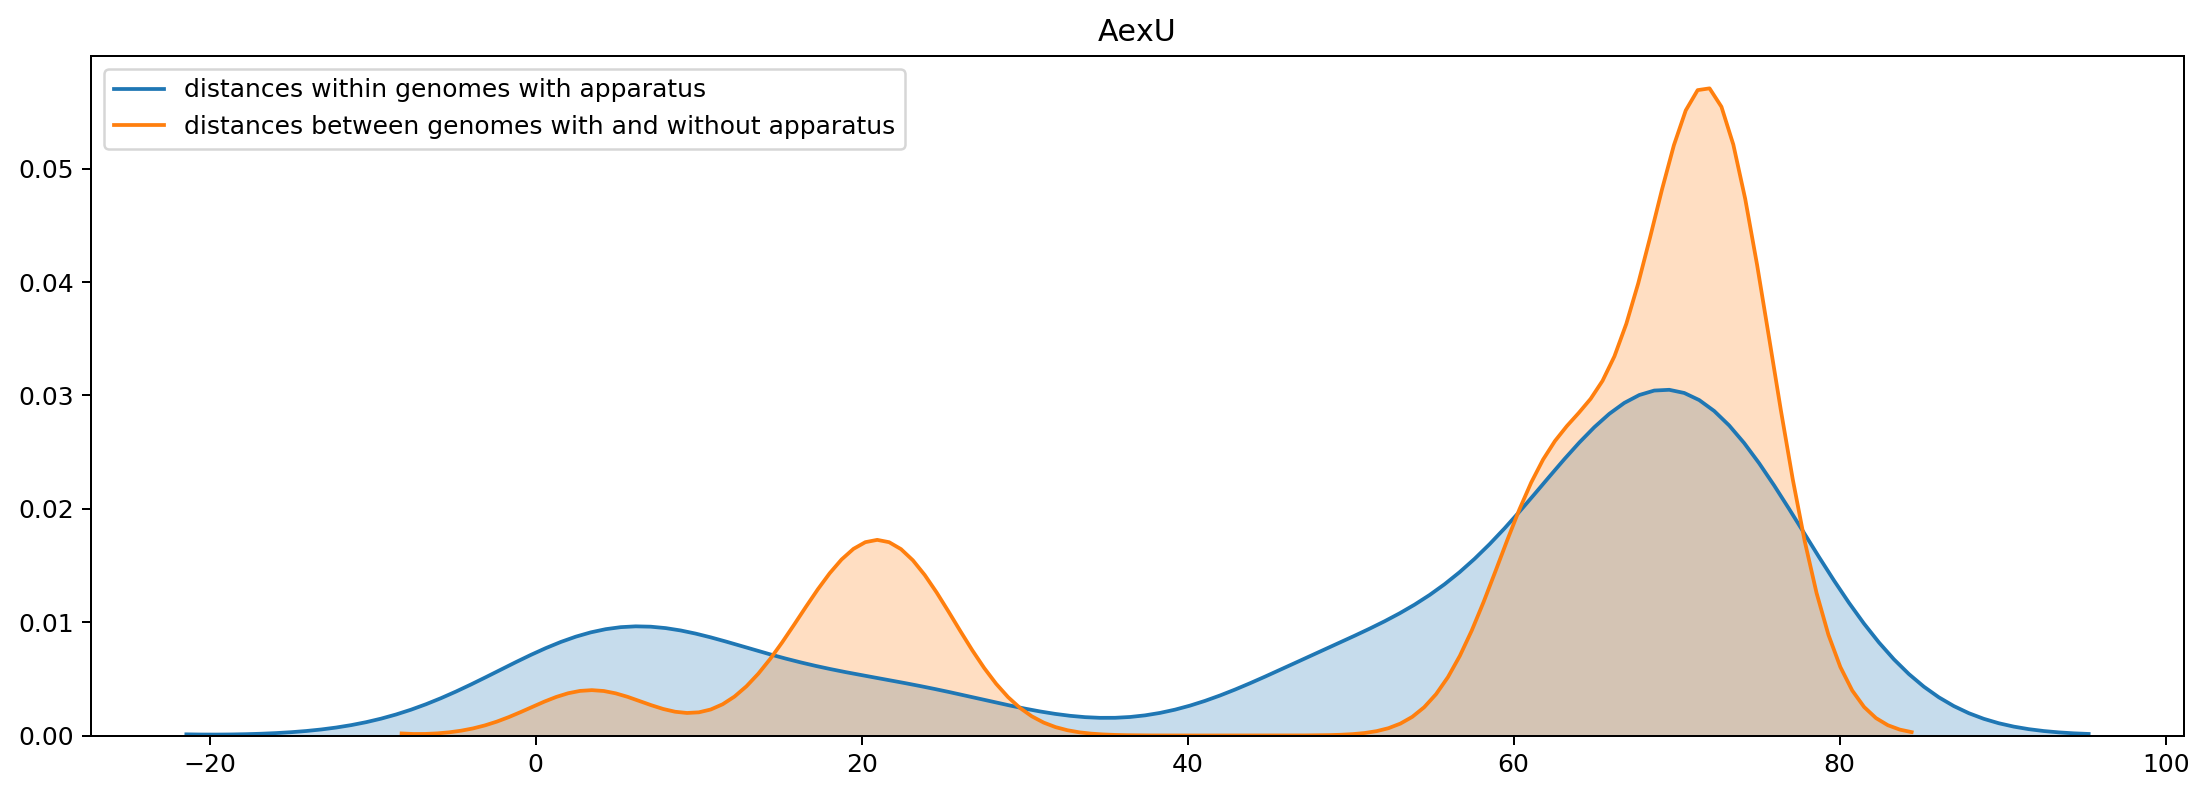

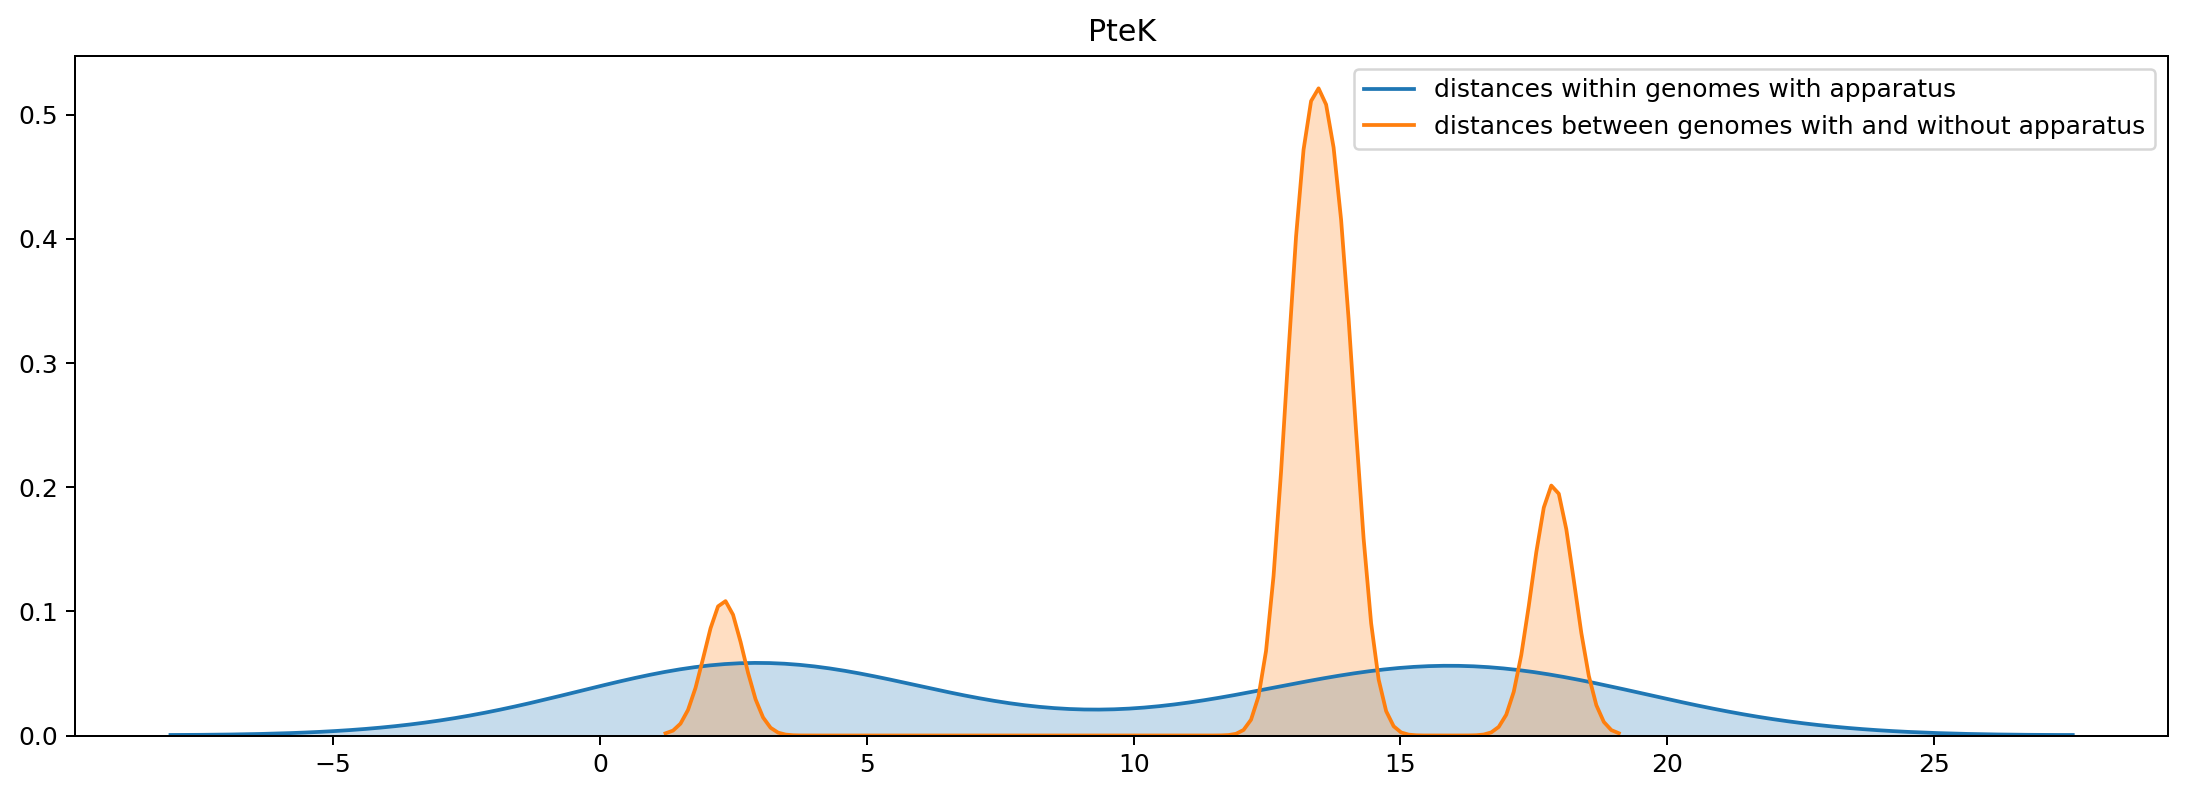

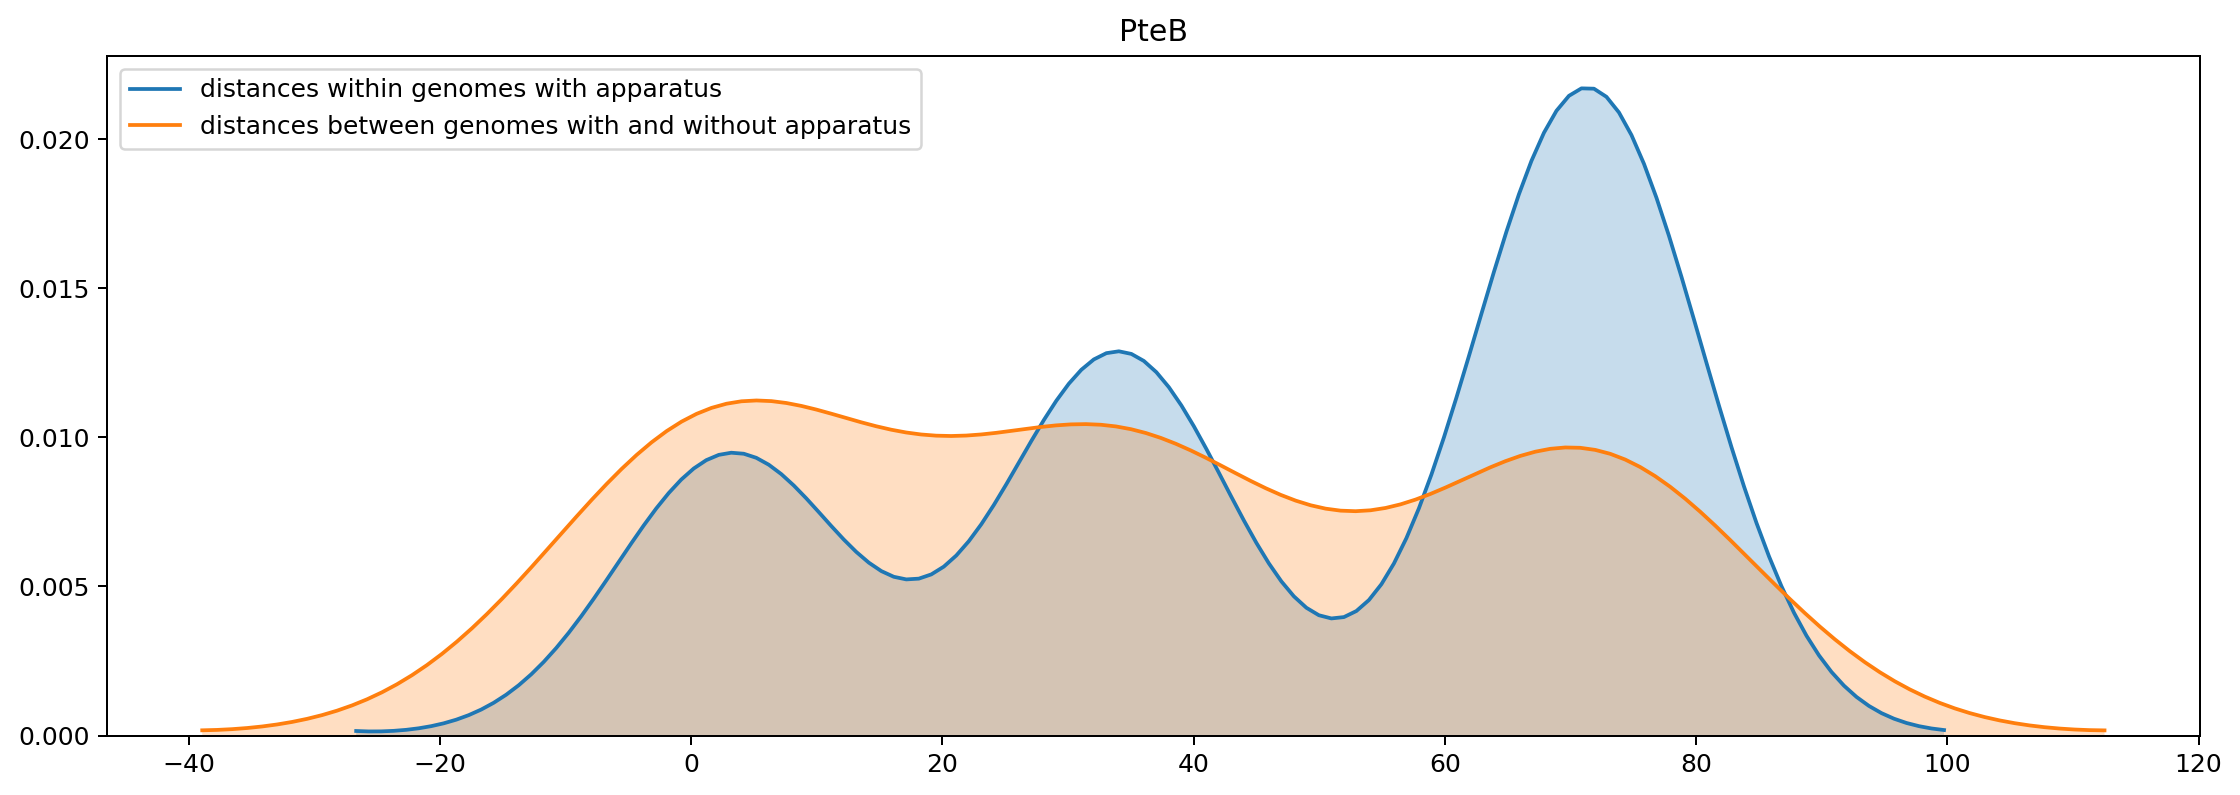

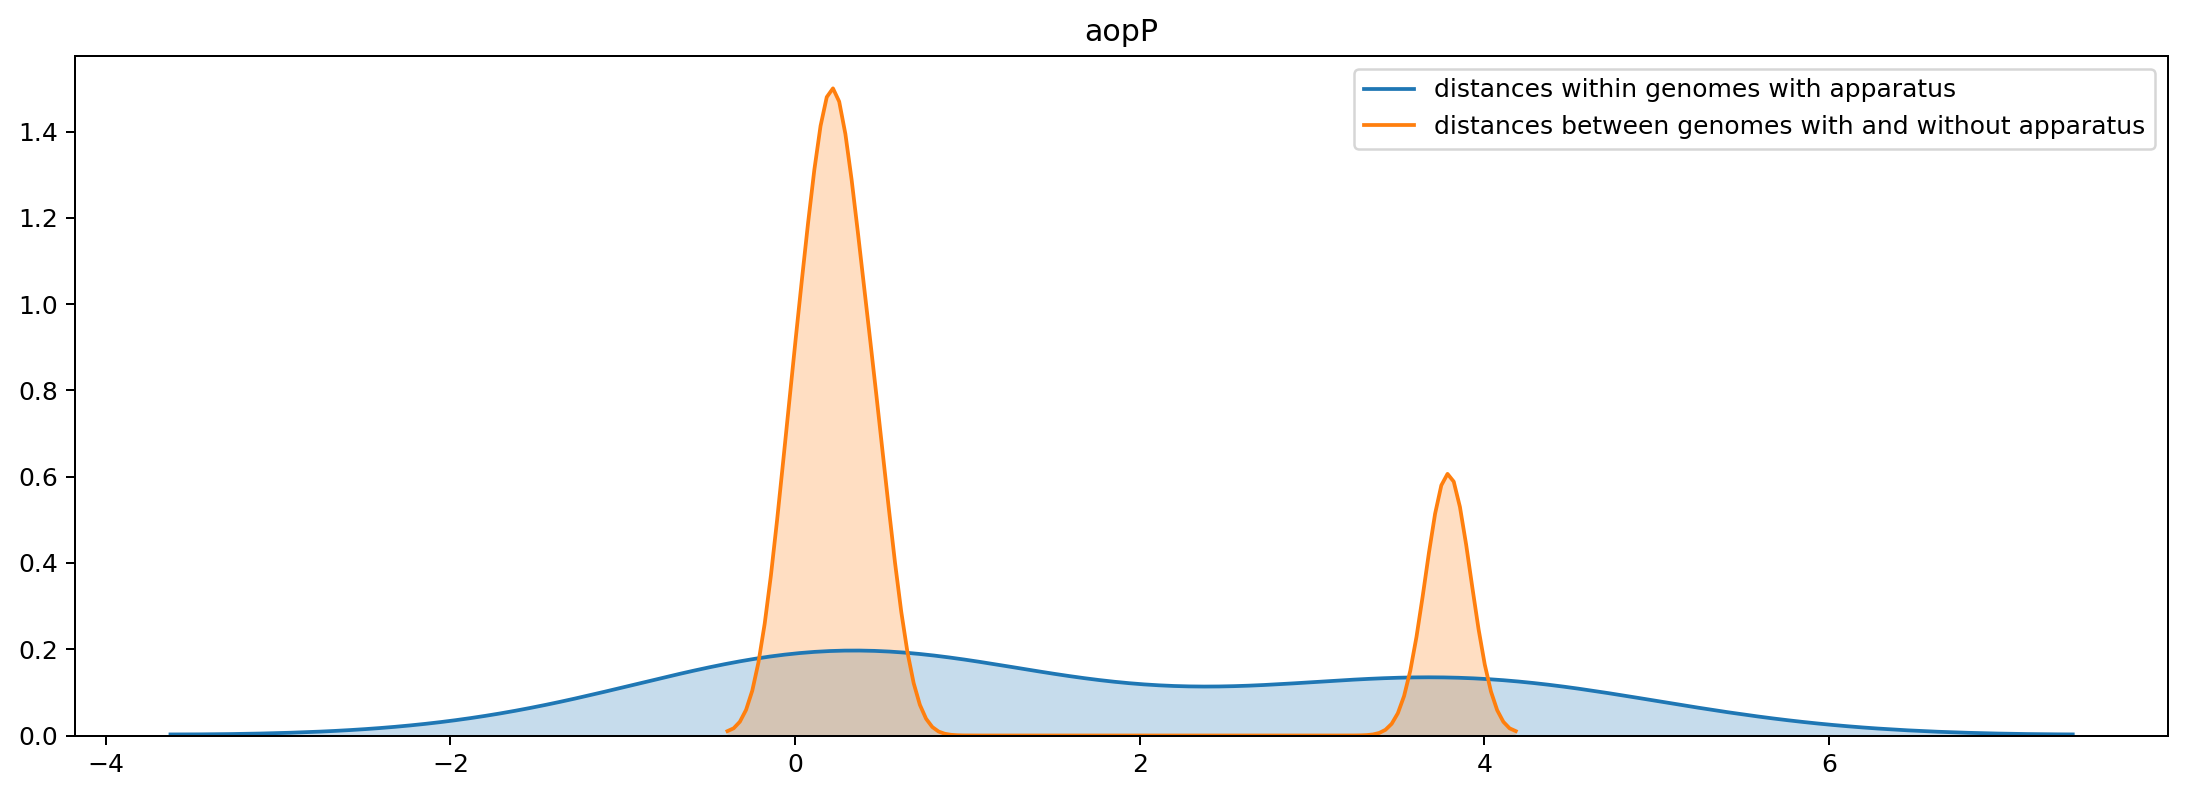

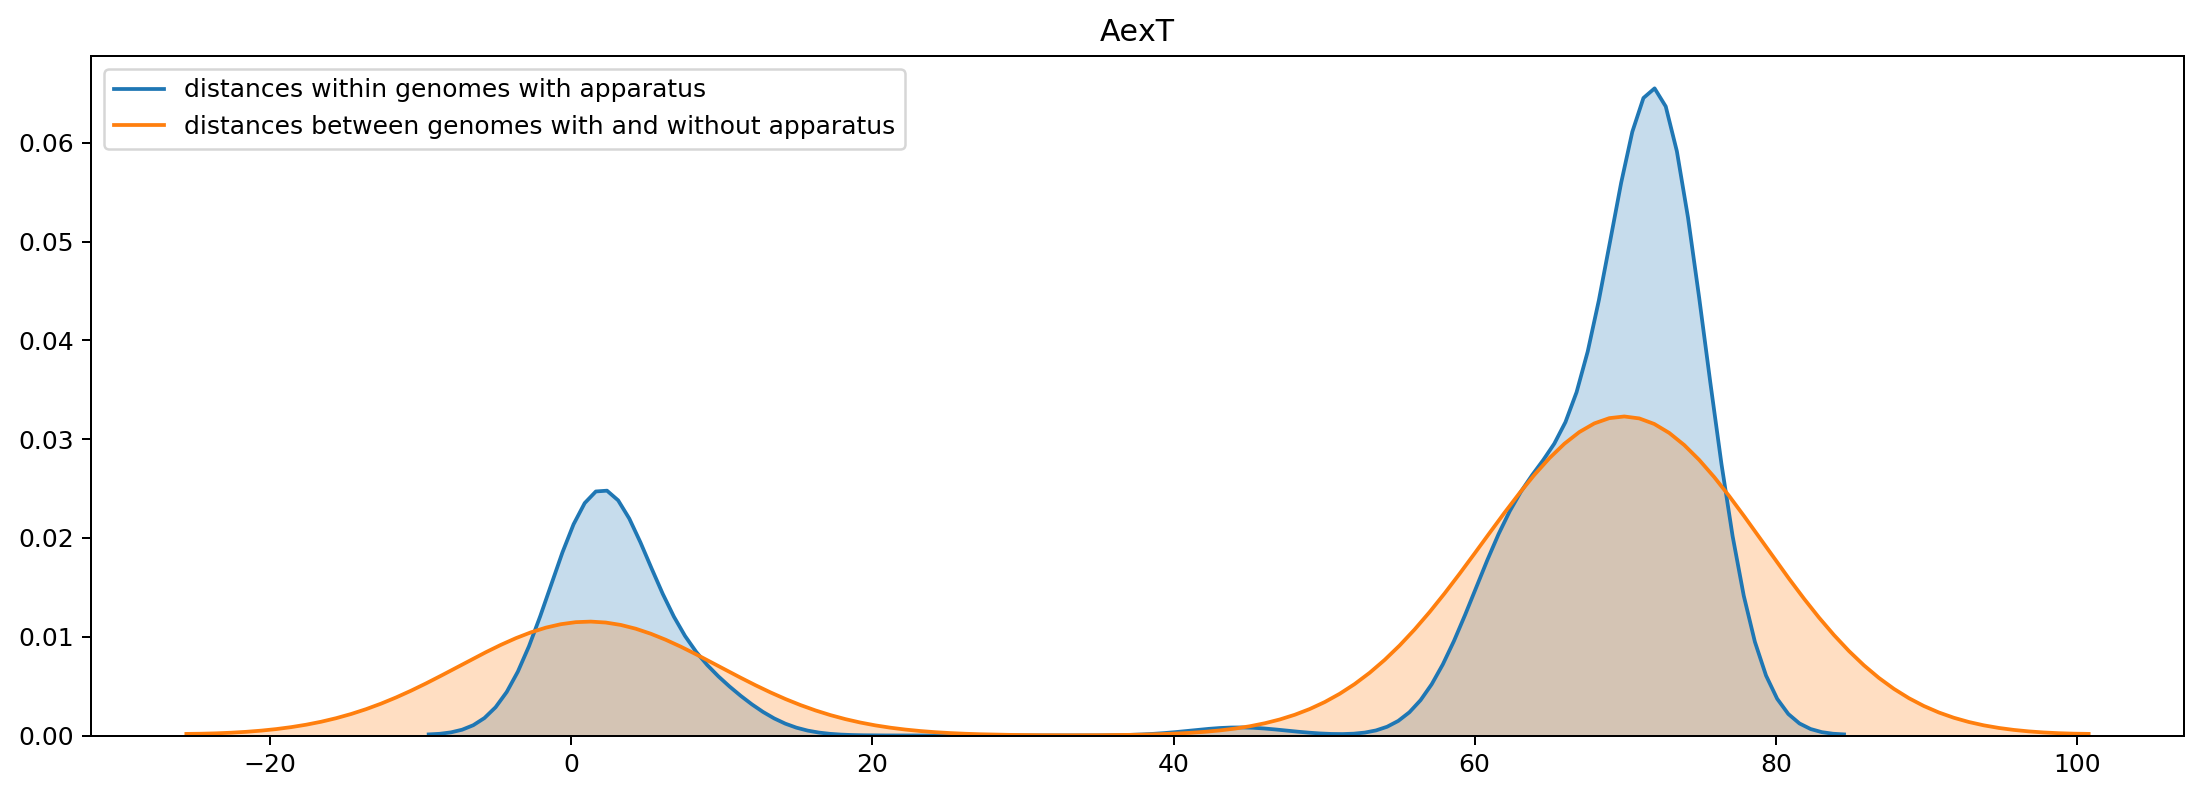

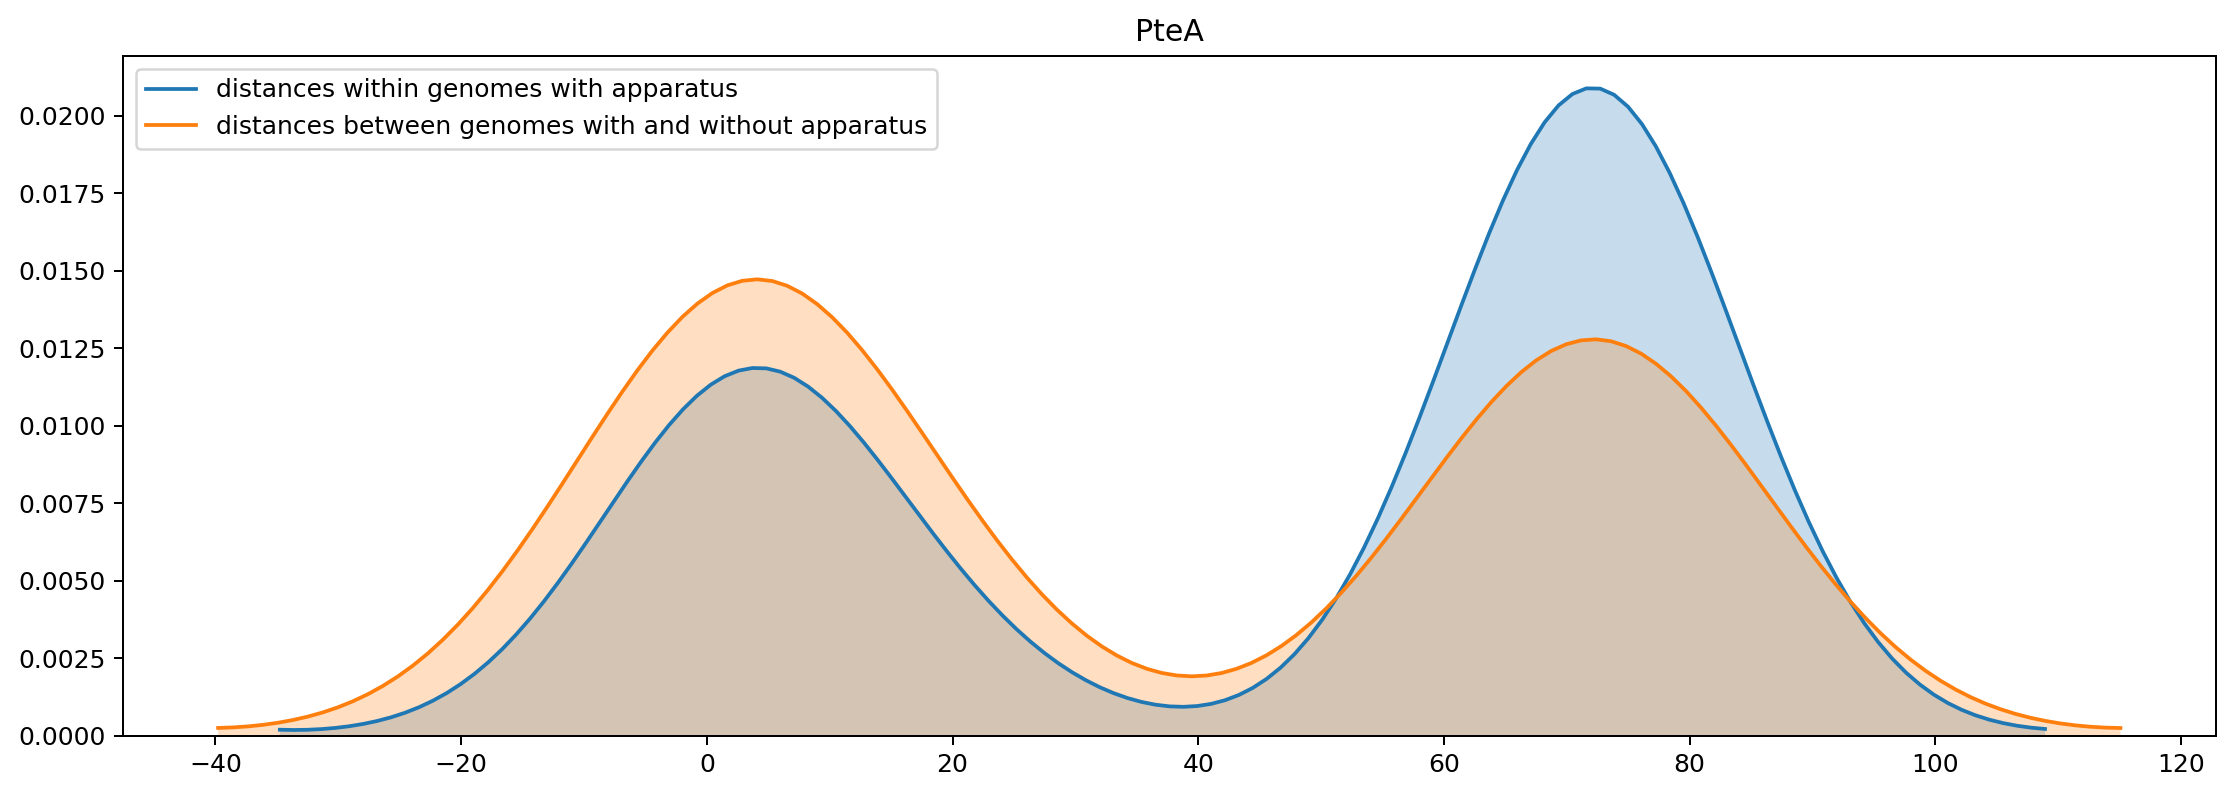

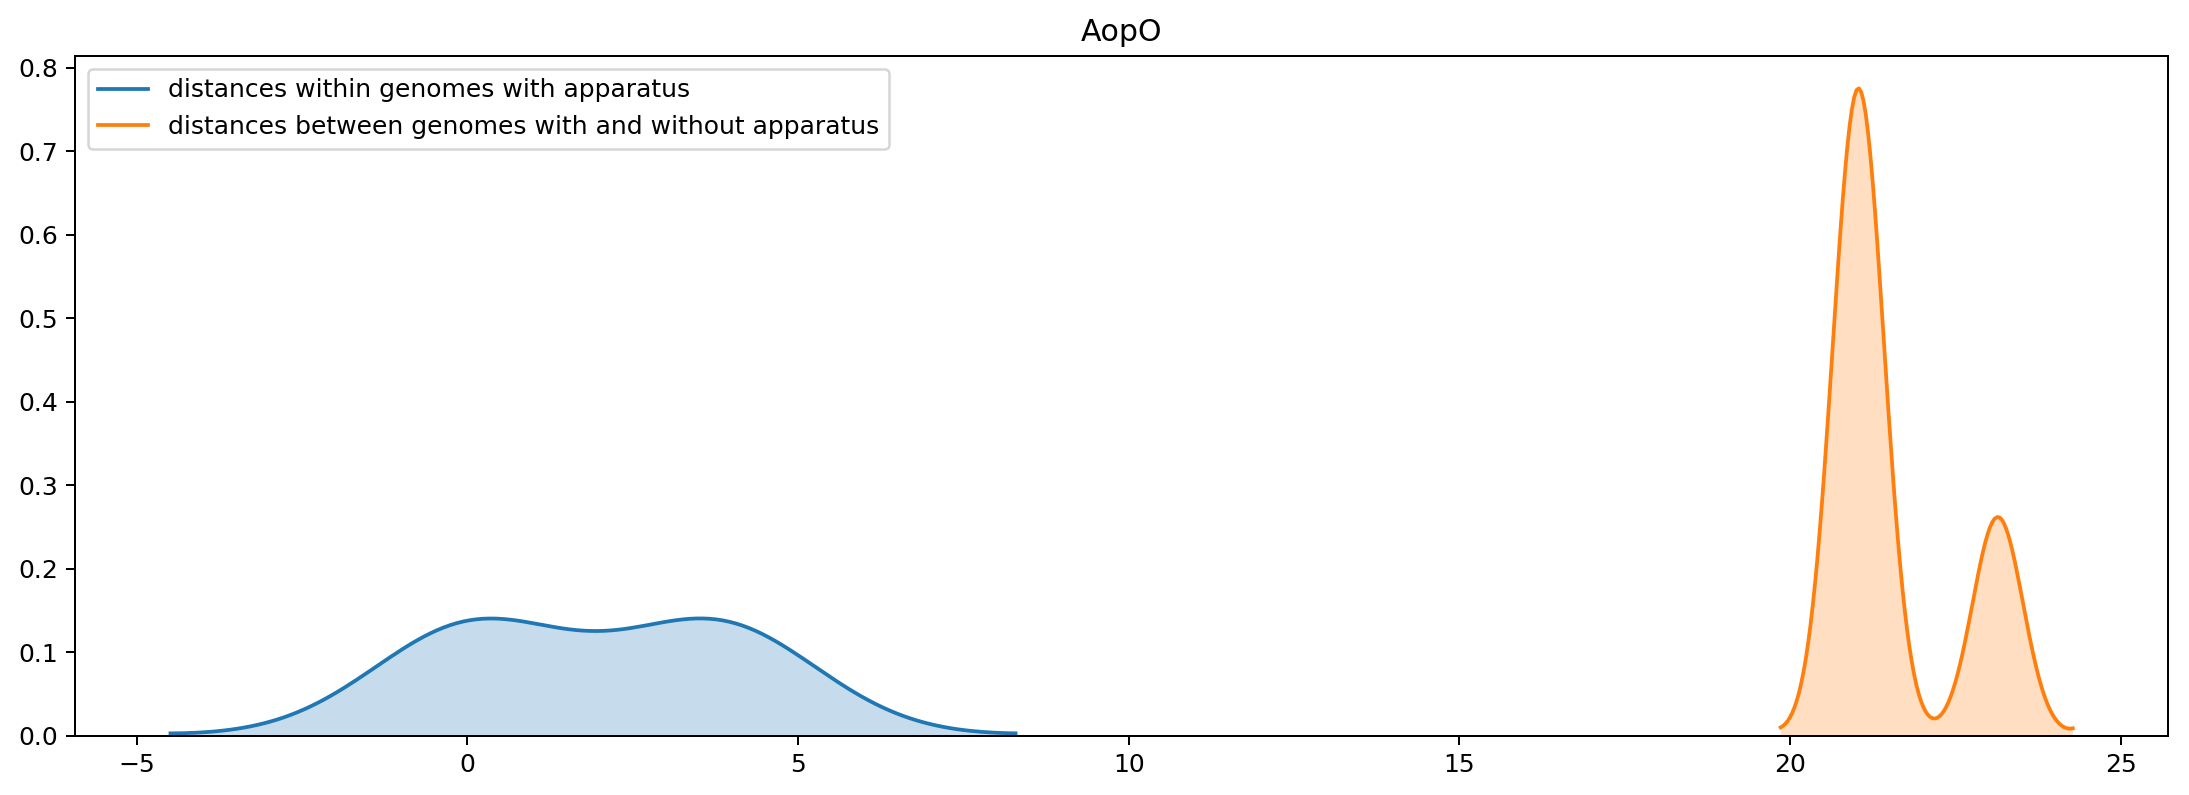

In [284]:
for distmat in os.listdir('distmats/'):
#    if distmat != 'aopP.distmat':
#        continue
    headers = []
    for tmp in re.findall('^>(\S+)', open('%s.fna' % distmat.replace('.distmat', '')).read(), re.M):
        tmp = tmp.split('|')
        if len(tmp) == 1:
            headers.extend(tmp)
        elif tmp[0].startswith('A_'):
            headers.append(tmp[0])
        else:
            headers.append(tmp[1])
    
    uncorrected_distances = pd.read_table('distmats/%s' % distmat,
                                          skiprows=7,
                                          usecols=range(1,len(headers)+2))
    uncorrected_distances.dropna(how='all', axis=1, inplace=True)
    uncorrected_distances.index   = headers
    uncorrected_distances.columns = headers

    lower_triangle_indexes = np.tril_indices(uncorrected_distances.shape[0], -1)
    uncorrected_distances.values[lower_triangle_indexes] = uncorrected_distances.T.values[lower_triangle_indexes]
    
    tmp_with    = with_apparatus.intersection(   headers)
    tmp_without = without_apparatus.intersection(headers)
    
    inter = [item for sublist in uncorrected_distances.loc[tmp_with, tmp_without].values for item in sublist]
#    inter = uncorrected_distances.loc[tmp_with, tmp_without].values.squeeze()
    intra = squareform(uncorrected_distances.loc[tmp_with, tmp_with].values)
    
    fig, ax = plt.subplots(figsize=(15,5), dpi=180)
    sns.kdeplot(intra, shade=True, ax=ax, label='distances within genomes with apparatus')
    sns.kdeplot(inter, shade=True, ax=ax, label='distances between genomes with and without apparatus')
    ax.set_title(distmat.replace('.distmat', ''))

In [309]:
genomes_with_apparatus2         = apparatus_df.index[apparatus_df['2']==1]
effectors_present_in_apparatus2 = effector_df.columns[effector_df.loc[genomes_with_apparatus2].sum() > 1]

In [312]:
effector_df.loc[genomes_with_apparatus2, effectors_present_in_apparatus2]

,PteD,PteG,PteF,PteB,AopX,PteC,PteA,AexU,AexT
A_sp_MDS8,1,0,0,0,0,1,0,0,0
A_jandaei_Ho603,0,1,1,0,0,0,0,0,0
A_diversa_CECT4254T,0,1,1,0,1,1,0,0,0
A_veronii_Hm21,1,0,0,1,1,1,1,1,1
A_veronii_G3C1,1,0,0,1,1,1,0,1,1
A_schubertii_CECT4240T,1,0,0,1,0,1,1,0,0


In [314]:
effector_df.loc[:, effectors_present_in_apparatus2].sum()

PteD     4
PteG     7
PteF     3
PteB    30
AopX    36
PteC     5
PteA    27
AexU    42
AexT    20
dtype: int64

In [315]:
effector_df[effector_df.PteF == 1]

,PteD,AopH,PteE,PteG,PteF,PteB,AopX,AopO,PteC,PteD.1,...,PteK,aopP,Ati2,PteJ,PteH,AopS,PteI,AexU,AexT,PteM.1
A_jandaei_Ho603,0,0,1,1,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
A_diversa_CECT4254T,0,0,0,1,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
A_tecta_CECT7082T,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
